In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm

In [3]:
def plot_data(fil, avg = None, raw = False, fit = None, Nx = None, type = None):
    '''Plots the mean time trace of all Pixel of a given file base name.
    'raw' can be used to plot the raw counts of meas and ctrl, otherwise
    the michelson contrast is given. If avg is given, only the first avg
    frames will be used in the analysis. Two different fitting models can be used:
    'cos_epx_dec' and 'exp_dec'. '''
    if avg == None:
        avg = int(fil.split('_')[-1].strip('x'))
    first_npz_file = np.load(fil+'_frames_01.npz')
    n_points = (first_npz_file['frames_meas'].shape)[0]
    all_meas_mean = np.zeros((avg,n_points))
    all_ctrl_mean = np.zeros((avg,n_points))


    for i in range(avg):
        npz_file = np.load(fil+'_frames_'+str(i+1).zfill(2)+'.npz')
        all_meas_mean[i] = np.mean(npz_file['frames_meas'], axis = (1,2))
        all_ctrl_mean[i] = np.mean(npz_file['frames_ctrl'], axis = (1,2))
    meas_mean = np.mean(all_meas_mean, axis = 0)
    ctrl_mean = np.mean(all_ctrl_mean, axis = 0)

    #For zooming in:
    if Nx == None:
        x_arr = get_x_axis(fil)
    else:               #zoom in
        x_arr = get_x_axis(fil)
        x_arr = x_arr[:Nx]
        meas_mean = meas_mean[:Nx]
        ctrl_mean = ctrl_mean[:Nx]
    
    print('x_arr = ', x_arr)

    fig,ax = plt.subplots()
    if raw:    
        ax.plot(x_arr, meas_mean)
        ax.plot(x_arr, ctrl_mean)
    else:
        ax.plot(x_arr, (meas_mean - ctrl_mean)/(meas_mean + ctrl_mean))
        if fit == 'exp_dec':
            fit_data, fit_params, fit_params_error = fit_exp((meas_mean-ctrl_mean)/(meas_mean + ctrl_mean), x_arr)
            ax.plot(x_arr, fit_data, label = '$\gamma\'$ = {:.3f} \u00B1 {:.3f}'.format(fit_params, fit_params_error))
            ax.legend()
            print(fit_params)
        elif fit == 'cos_exp_dec':
            fit_data, fit_params, fit_params_error = fit_cos_exp((meas_mean-ctrl_mean)/(meas_mean + ctrl_mean), x_arr, type)
            if type == 'gamma':
                ax.plot(x_arr, fit_data, label = '$\gamma\'$ = {:.3f} \u00B1 {:.3f}'.format(fit_params, fit_params_error))
            elif type =='period':
                ax.plot(x_arr, fit_data, label = '$\tau\'$ = {:.3f} \u00B1 {:.3f}'.format(fit_params, fit_params_error))
            ax.legend()
            print(fit_params)
        elif fit == 'mult_cos_exp_dec':
            fit_data, fit_params, fit_params_error = fit_mult_cos_exp((meas_mean-ctrl_mean)/(meas_mean + ctrl_mean), x_arr, type)
            ax.plot(x_arr, fit_data, label = '$\gamma\'$ = {:.3f} \u00B1 {:.3f}'.format(fit_params, fit_params_error))
            ax.legend()
            print(fit_params)
    ax.set_xlabel('tau [ns]')
    plt.show()
    
def plot_data_single_pixel(fil, pixels = None, avg = None, raw = False, fit = None, Nx = None, type = None):
    '''Plots the time trace of a single pixel of a given file base name.
    'raw' can be used to plot the raw counts of meas and ctrl, otherwise
    the michelson contrast is given. If avg is given, only the first avg
    frames will be used in the analysis. If more than one pixel is given,
    all will be plotted in the same plot and als normalized (to compare 
    the lineshape)'''
    if avg == None:
        avg = int(fil.split('_')[-1].strip('x'))    # get number of avergaes from file name
    first_npz_file = np.load(fil+'_frames_01.npz')
    shape = first_npz_file['frames_meas'].shape     # get number of x-values
    n_points = shape[0]
    if pixels == None:
        pixels = [(shape[1]//2, shape[2]//2)]  # take middle pixel

    fig,ax = plt.subplots()
    for pixel in pixels:
        all_meas_mean = np.zeros((avg,n_points))
        all_ctrl_mean = np.zeros((avg,n_points))
        for i in range(avg):
            npz_file = np.load(fil+'_frames_'+str(i+1).zfill(2)+'.npz')
            all_meas_mean[i] = npz_file['frames_meas'][:,pixel[0], pixel[1]]
            all_ctrl_mean[i] = npz_file['frames_ctrl'][:, pixel[0], pixel[1]]
        meas_mean = np.mean(all_meas_mean, axis = 0)
        ctrl_mean = np.mean(all_ctrl_mean, axis = 0)

        if Nx == None:
            x_arr = get_x_axis(fil)
        else:               #zoom in
            x_arr = get_x_axis(fil)
            x_arr = x_arr[:Nx]
            meas_mean = meas_mean[:Nx]
            ctrl_mean = ctrl_mean[:Nx]
            
        if len(pixels) > 1:
            meas_mean /= max(meas_mean)
            ctrl_mean /= max(ctrl_mean)
        if raw:    
            ax.plot(x_arr, meas_mean)
            ax.plot(x_arr, ctrl_mean)
        else:
            ax.plot(x_arr, (meas_mean - ctrl_mean)/(meas_mean + ctrl_mean))
            if fit == 'exp_dec':
                fit_data, fit_params, fit_params_error = fit_exp((meas_mean-ctrl_mean)/(meas_mean + ctrl_mean), x_arr)
                ax.plot(x_arr, fit_data, label = '$\gamma\'$ = {:.3f} \u00B1 {:.3f}'.format(fit_params, fit_params_error))
                ax.legend()
                print(fit_params)
            elif fit == 'cos_exp_dec':
                fit_data, fit_params, fit_params_error = fit_cos_exp((meas_mean-ctrl_mean)/(meas_mean + ctrl_mean), x_arr, type)
                if type == 'gamma':
                    ax.plot(x_arr, fit_data, label = '$\gamma\'$ = {:.3f} \u00B1 {:.3f}'.format(fit_params, fit_params_error))
                elif type =='period':
                    ax.plot(x_arr, fit_data, label = '$\tau\'$ = {:.3f} \u00B1 {:.3f}'.format(fit_params, fit_params_error))
                ax.legend()
                print(fit_params)
            elif fit == 'mult_cos_exp_dec':
                fit_data, fit_params, fit_params_error = fit_mult_cos_exp((meas_mean-ctrl_mean)/(meas_mean + ctrl_mean), x_arr, type)
                if type == 'gamma':
                    ax.plot(x_arr, fit_data, label = '$\gamma\'$ = {:.3f} \u00B1 {:.3f}'.format(fit_params, fit_params_error))
                elif type =='period1':
                    ax.plot(x_arr, fit_data, label = 'period1 = {:.3f} \u00B1 {:.3f}'.format(fit_params, fit_params_error))
                elif type =='period2':
                    ax.plot(x_arr, fit_data, label = 'period2 = {:.3f} \u00B1 {:.3f}'.format(fit_params, fit_params_error))
                ax.legend()
                print(fit_params)
    ax.set_xlabel('tau [ns]')
    plt.show()

def get_x_axis(fil):    # get tau array from .pys file of measurement
    f = np.load(fil + '.pys', allow_pickle = True, encoding='latin1')
    return f['tau']


def plot_2D_map(fil, avg = None, Nx = None, fit = None, type = None):
    if avg == None:
        avg = int(fil.split('_')[-1].strip('x'))
    first_npz_file = np.load(fil+'_frames_01.npz')
    n_points, nx, ny = (first_npz_file['frames_meas'].shape)
    all_meas = np.zeros((avg,n_points, nx, ny))
    all_ctrl = np.zeros((avg,n_points, nx, ny))

    for i in range(avg):
        npz_file = np.load(fil+'_frames_'+str(i+1).zfill(2)+'.npz')
        all_meas[i] = npz_file['frames_meas']
        all_ctrl[i] = npz_file['frames_ctrl']
    meas_mean = np.mean(all_meas, axis = 0)
    ctrl_mean = np.mean(all_ctrl, axis = 0)

    if Nx == None:
        x_arr = get_x_axis(fil)
    else:               #zoom in
        x_arr = get_x_axis(fil)
        x_arr = x_arr[:Nx]
        meas_mean = meas_mean[:Nx]
        ctrl_mean = ctrl_mean[:Nx]

    def fit_all_pixel(mean_data):                           #fit all pixels
        print(mean_data.shape)
        n_tau, n_x, n_y = mean_data.shape
        mapping = np.zeros((n_x, n_y))
        fit_data = np.zeros_like(mean_data)
        for x in range(n_x):
            for y in range(n_y):
                if fit == 'exp_dec':
                    fit_data[:,x,y], mapping[x,y], _ = fit_exp(mean_data[:,x,y], x_arr)
                elif fit == 'cos_exp_dec':
                    fit_data[:,x,y], mapping[x,y], _ = fit_cos_exp(mean_data[:,x,y], x_arr, type)
                elif fit == 'mult_exp_dec':
                    fit_data[:,x,y], mapping[x,y], _ = fit_mult_cos_exp(mean_data[:,x,y], x_arr, type)
                #plt.plot(fit_data[:,x,y])
                #plt.show()
        return fit_data, mapping
    
    global all_mapping
    all_fit_data , all_mapping = fit_all_pixel((meas_mean - ctrl_mean)/(meas_mean + ctrl_mean))
    plt.imshow(all_mapping)
    plt.colorbar()
    plt.show()

# def fit_all_pixel(mean_data):
#     print(mean_data.shape)
#     n_tau, n_x, n_y = mean_data.shape
#     gammas = np.zeros((n_x, n_y))
#     fit_data = np.zeros_like(mean_data)
#     for x in range(n_x):
#         for y in range(n_y):
#             fit_data[:,x,y], gammas[x,y], _ = fit_cos_exp(mean_data[:,x,y], x_arr)           
#             #plt.plot(fit_data[:,x,y])
#             #plt.show()
#     return fit_data, gammas

def exp_dec(x, amp, gamma, offset):
    return amp * np.exp(-x/gamma) + offset

def cos_exp_dec(x, amp, gamma, offset, phase, period):
    return amp * np.exp(-x/gamma)*np.cos(2*np.pi/period*x + phase) + offset

def mult_cos_exp_dec(x, gamma, offset, amp, period1, phase1, period2, phase2):
    return np.exp(-x/gamma)*amp*np.cos(2*np.pi/period1*x + phase1)*np.cos(2*np.pi/period2*x + phase2) + offset

def fit_exp(trace, x_arr):
    model = lm.Model(exp_dec)
    params_model = model.make_params(amp = 0.07, offset = -0.07, gamma = 10)
    fit_res = model.fit(trace, params_model, x = x_arr)
    fittrace = model.eval(fit_res.params, x = x_arr)
    #print(fit_res.fit_report())
    return fittrace, fit_res.params['gamma'].value, fit_res.params['gamma'].stderr

def fit_cos_exp(trace, x_arr, type):
    model = lm.Model(cos_exp_dec)
    params_model = model.make_params(amp = 0.07, offset = -0.07, gamma = 10, period = 50, phase = 0)
    # params_model['phase'].set(min=-np.pi, max=np.pi)             #set constrains
    # params_model['period'].set(min=0, max=np.inf)             #set constrains
    fit_res = model.fit(trace, params_model, x = x_arr)
    fittrace = model.eval(fit_res.params, x = x_arr)
    print(fit_res.fit_report())
    if type == 'gamma':
        return fittrace, fit_res.params['gamma'].value, fit_res.params['gamma'].stderr
    elif type == 'period':
        return fittrace, fit_res.params['period'].value, fit_res.params['period'].stderr

def fit_mult_cos_exp(trace, x_arr, type):
    model = lm.Model(mult_cos_exp_dec)
    params = lm.Parameters()
    #params.add_many(('amp', 0.07), ('offset', -0.07), ('gamma', 10), ('period1', 50, True, 0), ('phase1', 0, True,0), ('period2', 60, True,0), ('phase2', 0.1, True,0))
    params_model = model.make_params(amp = 0.07, offset = -0.07, gamma = 10, period1 = 50, phase1 = 0, period2 = 60, phase2 = 0.1)
    fit_res = model.fit(trace, params_model, x = x_arr)
    fittrace = model.eval(fit_res.params, x = x_arr)
    #fit_res = model.fit(trace, params, x = x_arr)
    print(fit_res.fit_report())
    if type == 'gamma':
        return fittrace, fit_res.params['gamma'].value, fit_res.params['gamma'].stderr
    elif type == 'period1':
        return fittrace, fit_res.params['period1'].value, fit_res.params['period1'].stderr
    elif type == 'period2':
        return fittrace, fit_res.params['period2'].value, fit_res.params['period2'].stderr
    print(fit_res.fit_report())
    



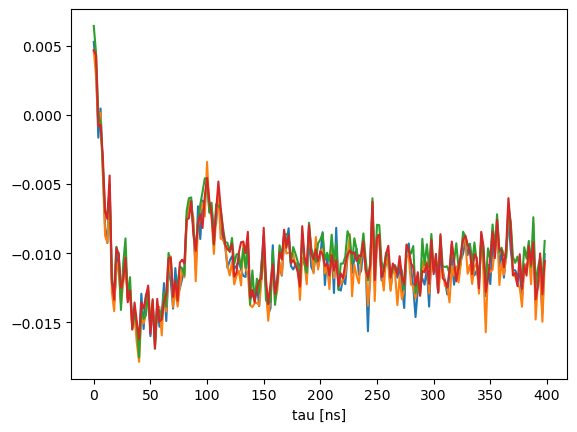

In [158]:
#plot_data(r'data\013_Rabi_X_2.8704GHz_0.0dBm_6x', raw = True)
#plot_data(r'data\071 Rabi_AWG_2.8710GHz_0.0dBm_50x', raw = False, fit = 'exp_dec')
#plot_data(r'data\073 Rabi_AWG_2.8710GHz_-5.0dBm_10x', raw = False, fit = 'exp_dec')
#plot_data(r'data\075 Rabi_AWG_2.8710GHz_-10.0dBm_5x', fit = True)
#plot_data_single_pixel(r'data\071 Rabi_AWG_2.8710GHz_0.0dBm_50x', raw = False, pixels = [(0,0)])
#plot_data_single_pixel(r'data\071 Rabi_AWG_2.8710GHz_0.0dBm_50x', raw = False, pixels = [(19,19)])
#plot_2D_gamma(r'data\071 Rabi_AWG_2.8710GHz_0.0dBm_50x')
#plot_2D_gamma(r'data\075 Rabi_AWG_2.8710GHz_-10.0dBm_5x')
#plot_data(r'data\084 Rabi_AWG_2.8240GHz_-5.0dBm_1x', raw = True)
plot_data_single_pixel(r'035 Rabi_AWG_2.7100GHz_0.0dBm_10x', raw = False, pixels = [(0,0),(10,0),(0,10),(5,5)])
#plot_data(r'data\085 Rabi_AWG_2.8240GHz_-5.0dBm_1x', raw = True)
#plot_data(r'data\086 Rabi_AWG_2.8240GHz_-5.0dBm_10x', raw = False, fit = 'exp_dec')
#plot_data(r'data\086 Rabi_AWG_2.8240GHz_-5.0dBm_10x', raw = False, fit = 'cos_exp_dec')
#plot_data(r'data\086 Rabi_AWG_2.8240GHz_-5.0dBm_10x', raw = False, fit = 'mult_cos_exp_dec')
#plot_data_single_pixel(r'data\086 Rabi_AWG_2.8240GHz_-5.0dBm_10x', raw = True,  pixels = [(0,0),(10,0),(0,10),(5,5)])

x_arr =  [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46
 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94
 96 98]
[[Model]]
    Model(cos_exp_dec)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2089
    # data points      = 50
    # variables        = 5
    chi-square         = 1.1445e-04
    reduced chi-square = 2.5433e-06
    Akaike info crit   = -639.370684
    Bayesian info crit = -629.810569
    R-squared          = 0.90298178
[[Variables]]
    amp:     6.05004711 +/- 61833.3523 (1022030.92%) (init = 0.07)
    gamma:   49.4237796 +/- 8.25070059 (16.69%) (init = 10)
    offset:  0.01025225 +/- 0.07197737 (702.06%) (init = -0.07)
    phase:   1.57234712 +/- 15.9179161 (1012.37%) (init = 0)
    period:  27377.4089 +/- 2.7978e+08 (1021927.72%) (init = 50)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, period)    = +1.0000
    C(phase, period)  = -1.0000
    C(amp, phase)     = -1.0000
   

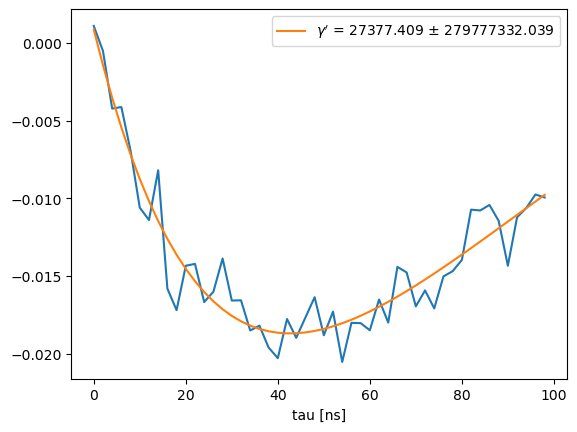

(200, 101, 50)
[[Model]]
    Model(cos_exp_dec)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 108
    # data points      = 200
    # variables        = 5
    chi-square         = 6.0234e-04
    reduced chi-square = 3.0889e-06
    Akaike info crit   = -2532.59958
    Bayesian info crit = -2516.10799
    R-squared          = 0.63355839
[[Variables]]
    amp:     0.01235672 +/- 0.00107030 (8.66%) (init = 0.07)
    gamma:   57.3478523 +/- 6.25210006 (10.90%) (init = 10)
    offset: -0.01440736 +/- 1.3058e-04 (0.91%) (init = -0.07)
    phase:   0.34578768 +/- 0.08933940 (25.84%) (init = 0)
    period:  107.822125 +/- 3.91297504 (3.63%) (init = 50)
[[Correlations]] (unreported correlations are < 0.100)
    C(phase, period)  = +0.7857
    C(amp, gamma)     = -0.7199
    C(amp, phase)     = +0.5327
    C(amp, period)    = +0.4132
    C(gamma, phase)   = -0.3592
    C(offset, phase)  = +0.2847
    C(gamma, period)  = -0.2691
    C(offset, period) = +0.2130
[[Model

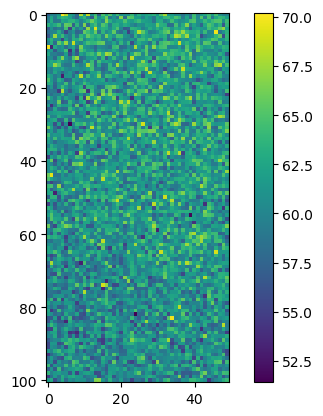

In [8]:
plot_data(r'035 Rabi_AWG_2.7100GHz_0.0dBm_10x', raw = False, fit = 'cos_exp_dec', Nx = 50, type = 'period')
#plot_data_single_pixel(r'035 Rabi_AWG_2.7100GHz_0.0dBm_10x', raw = False, pixels = [(0,0),(20,0),(0,20)], fit = 'cos_exp_dec', type = 'gamma')
# plot_2D_map(r'035 Rabi_AWG_2.7100GHz_0.0dBm_10x', fit = 'cos_exp_dec' ,type = 'period')
plot_2D_map(r'035 Rabi_AWG_2.7100GHz_0.0dBm_10x', fit = 'cos_exp_dec' ,type = 'gamma')

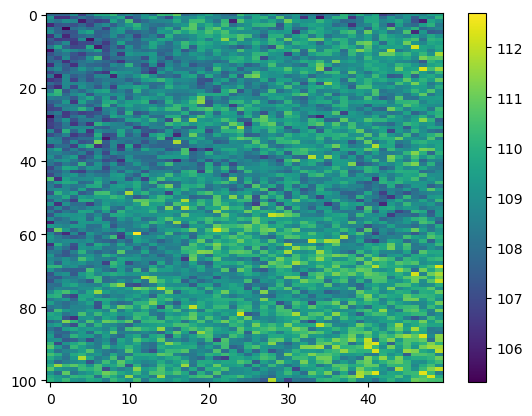

In [5]:
im = plt.imshow(all_mapping, aspect = 'auto', label = 'Period')
cbar = plt.colorbar(im)
# im.set_cmap('plasma')
# im.set_clim(100, 115)
im

(101, 50)


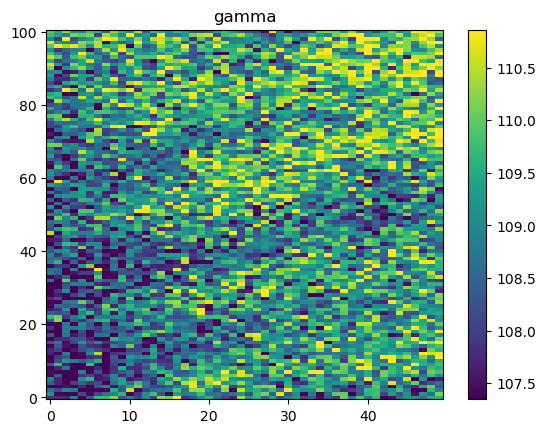

In [7]:
print(np.shape(all_mapping))
# np.arange(all_mapping.shape[0])

norm = ((all_mapping - np.min(all_mapping))*100 / ((np.max(all_mapping)) - np.min(all_mapping)))
low_centile = 5
high_centile = 95

plt.pcolormesh(np.arange(all_mapping.shape[1]) , np.arange(all_mapping.shape[0]) , all_mapping , vmin =np.nanpercentile(all_mapping, low_centile) , vmax = np.nanpercentile(all_mapping, high_centile))
# plt.pcolormesh(np.arange(norm.shape[1]) , np.arange(norm.shape[0]) , norm , vmin =np.nanpercentile(norm, low_centile) , vmax = np.nanpercentile(norm, high_centile))
plt.colorbar()
plt.title('gamma')
plt.show()